# Topic Modelling

Hinweis: um diesen Notebook auszuführen, musst du vorher die SpaCy-Bibliothek `de_core_news_lg` installieren. Das kannst du mit folgendem Befehl in deiner Kommandozeile machen:
```
python -m spacy download de_core_news_lg
```

## Setup

In [1]:
import matplotlib.pyplot as plt
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import spacy
from multiprocess import Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
tweet_csv = '../data/copbird_table_tweet.csv'

In [3]:
NUM_TOPICS=10
NUM_FEATURES=1000
NUM_TOP_WORDS=25

## Datenimport

In [4]:
def get_tweets(path, limit=None):
    df_csv = pd.read_csv(path, nrows=limit, parse_dates=['created_at'],
                         encoding='utf-8-sig')

    df_csv.drop(columns=['created_at', 'like_count', 'retweet_count', 'reply_count', 'quote_count'], inplace=True)

    nlp = spacy.load("de_core_news_lg")
    nlp.Defaults.stop_words |= {"&amp", "amp"}
    nlp.add_pipe('emoji', first=True)
    return list(
        nlp.pipe(df_csv['tweet_text'], disable=["tok2vec", "tagger", "parser", "attribute_ruler"], n_process=-1))

In [5]:
limit = 1000  # erst einmal limitiert, ansonsten kann die Auswertung sehr lange dauern
tweets = get_tweets(tweet_csv, limit)

## Datenbereinigung

In [6]:
def clean_tweet(doc):
    token_list = []

    for token in doc:
        if not token.is_alpha or token._.is_emoji or token.like_url or token.like_email or token.is_stop:
            pass
        else:
            token_list.append(token.lemma_)
    return ' '.join(token_list)

In [7]:
def get_cleaned(twts):
    with Pool() as p:
        cleaned_twts = p.map_async(clean_tweet, twts).get()
    return cleaned_twts

In [8]:
cleaned = get_cleaned(tweets) # das kann eine Weile dauern

## Vektorisieren der Tokens

In [9]:
vectorizer = CountVectorizer(min_df=3, max_df=0.95, max_features=NUM_FEATURES)
tweets_vectorized = vectorizer.fit_transform(cleaned)
tweets_vectorized

<1000x851 sparse matrix of type '<class 'numpy.int64'>'
	with 6464 stored elements in Compressed Sparse Row format>

In [10]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online', n_jobs=-1, verbose=True)
lda.fit(tweets_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(learning_method='online', n_jobs=-1, verbose=True)

## Anzeigen der Topics

In [11]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

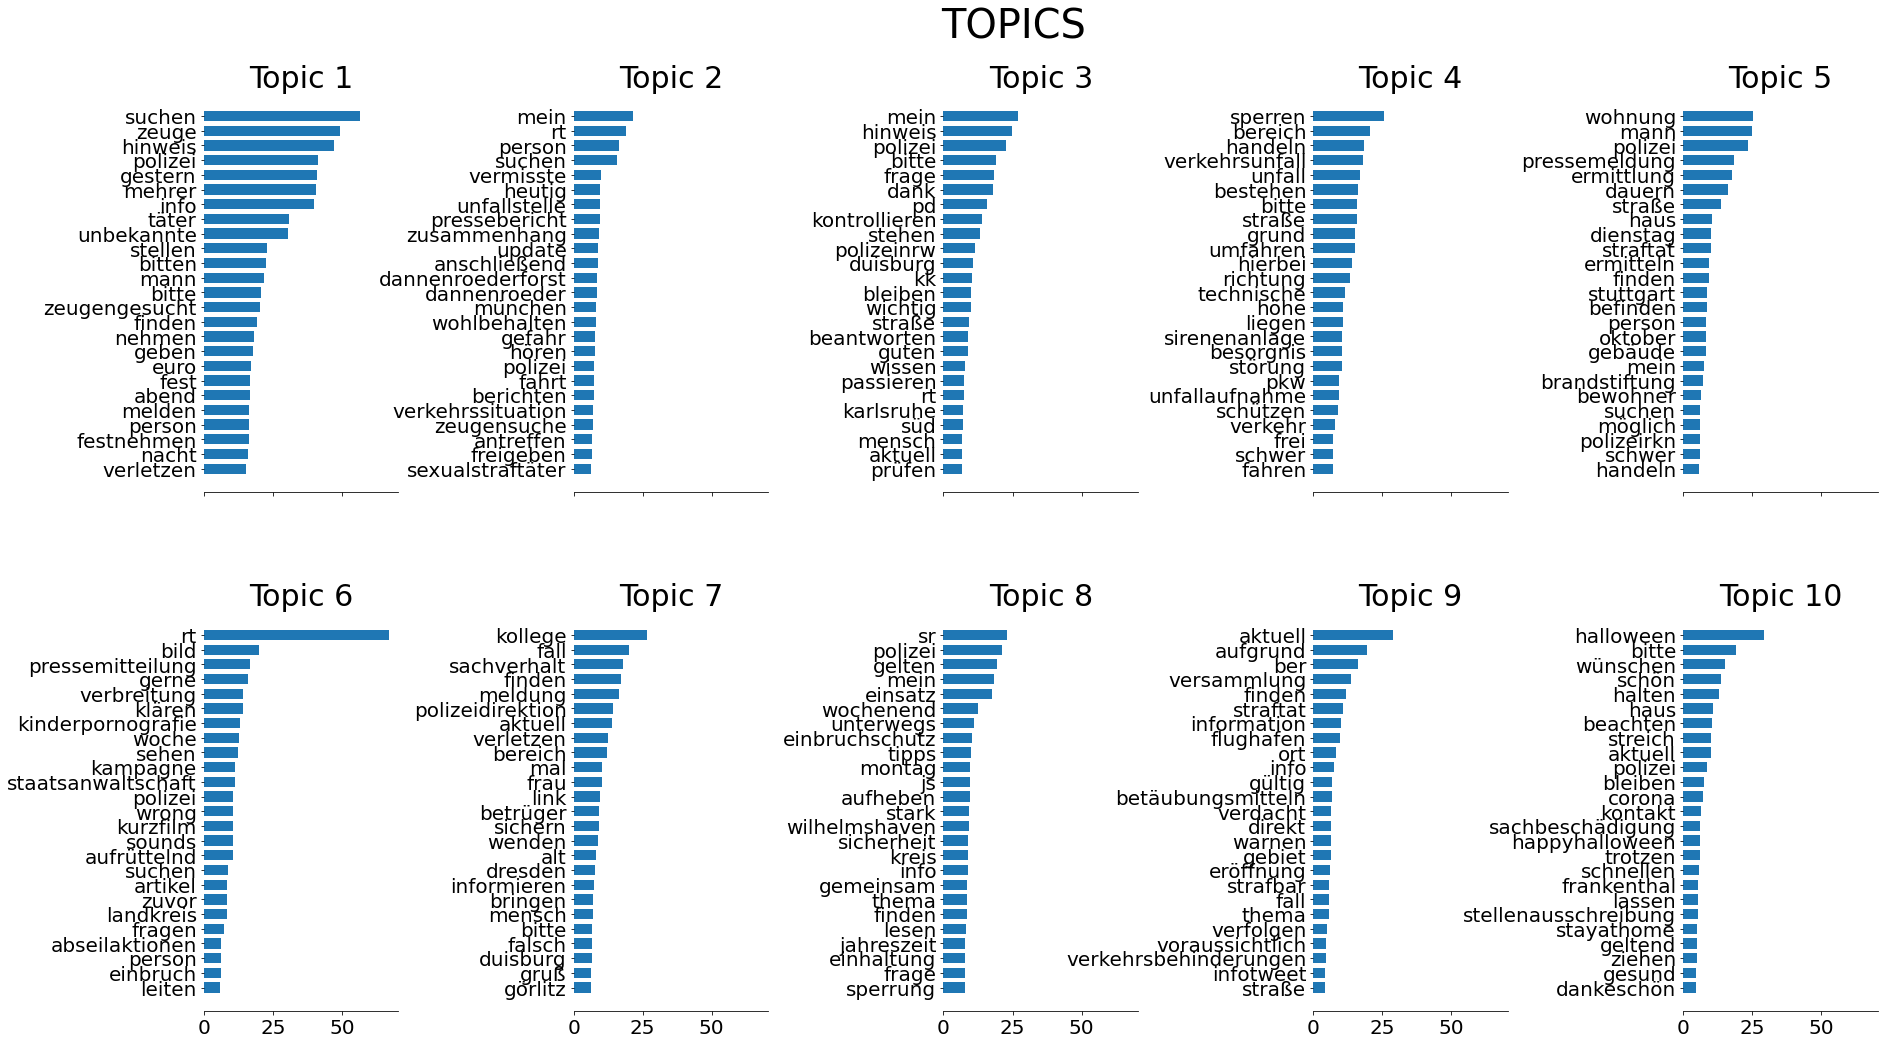

In [12]:
lda_feature_names = vectorizer.get_feature_names()
plot_top_words(lda, lda_feature_names, NUM_TOP_WORDS, 'TOPICS')

In [13]:
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, tweets_vectorized, vectorizer, mds='tsne')
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  24.117717
2       0.648955  71.707100       2        1  10.196038
7      71.019684   9.971006       3        1   9.664012
6       3.785981  33.185135       4        1   9.509067
3     -42.666500  -9.222070       5        1   9.347744
4      -3.621689 -43.526516       6        1   9.006547
5      -3.632402  -4.171708       7        1   7.991959
1     -36.584400  35.804413       8        1   7.592198
9      44.391380  50.615383       9        1   6.444453
8      40.235809 -31.591665      10        1   6.130264, topic_info=                      Term       Freq      Total Category  logprob  loglift
571                     rt  83.000000  83.000000  Default  30.0000  30.0000
12                 aktuell  58.000000  58.000000  Default  29.0000  29.0000
313              halloween  25.000000  25.000000  Default  28.0000  28.0000
339                hinweis  66.000000  66.000000  Default  27.0000  27.0000
442                   mein  74.000000  74.000000  Default  26.0000  26.0000
..                     ...        ...        ...      ...      ...      ...
733  verkehrsbehinderungen   3.921429   8.519369  Topic10  -4.6423   2.0160
684                  thema   4.844359  14.304430  Topic10  -4.4310   1.7092
353                   info   6.400345  52.820203  Topic10  -4.1524   0.6814
230                   fall   4.995611  23.425053  Topic10  -4.4002   1.2467
655                 straße   3.537225  48.064464  Topic10  -4.7454   0.1827

[493 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1         1  0.920691         abend
1        10  0.061379         abend
2         9  0.911818      ablaufen
3         5  0.770857      ableiten
4         6  0.864979   abschließen
...     ...       ...           ...
837       8  0.637713  zusammenhang
839       7  0.950912         zuvor
842      10  0.712669        ändern
848       4  0.847019     übergeben
850       3  0.708117    überprüfen

[656 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 8, 7, 4, 5, 6, 2, 10, 9])